In [1]:
%load_ext autoreload  
%autoreload 2

- Rerun models (w/o autoencoder features) on expanded dataset
- [DONE] Spatial CV
- Code for general pipeline options
  - Make sure to have option which drops facebook data, HDX conflict and healthcare data (all NGA specific), and low-res autoencoder, as won't have
- Train with spatial CV
- Population thresholding for data copying / brief consideration of better way of extrapolating / locating data
- Ordinal regression (Marina?)
- Additional country data (!!)
- Feature importance for actual models hyperparams, rather than default
- Process full dataset for simple ftrs
- Feature engineering? Probably unnecessary given autoencoder
- Uncertainty estimates (reasonable bounds from MAPIE now?)
- Predictions for Nigeria
- Alt vis to Marina's, e.g. [streamlit + vaex](https://medium.com/@jovan.veljanoski/streamlit-vaex-where-simplicity-meets-big-data-d7221b54bea4)
- End-to-end training? ([transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) - really [feature extraction](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/df1f5ef1c1a8e1a111e88281b27829fe/finetuning_torchvision_models_tutorial.ipynb#scrollTo=DJr9A3sXpHnG) rather than finetuning, as wouldn't update all params) 
- Documentation
- Model serving? I.e. dockerise + API requests for area predictions
- DVC
- Include other [normalised difference indices](https://www.geo.university/pages/blog?p=spectral-indices-with-multispectral-satellite-data), and/or high-res data through [another](https://eodag.readthedocs.io/en/latest/index.html) service

In [2]:
import pandas as pd
import geopandas as gpd
import swifter

pd.set_option("display.max_columns", None)
import numpy as np
import matplotlib.pyplot as plt
import stc_unicef_cpi.data.process_geotiff as pg
import h3.api.numpy_int as h3

from pathlib import Path


In [44]:
from stc_unicef_cpi.data.cv_loaders import cv_split  

In [25]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
nga = world[world.name == "Nigeria"].geometry.__geo_interface__['features'][0]['geometry']
nga_hex = h3.polyfill(nga,res=7)

In [35]:
base_dir = Path("/Users/johnf/Downloads/higher_res_dssg/")
all_data = base_dir / "clean_nga_w_autov1.csv"
thr_data = base_dir / "nga_clean_v2_thr30.csv"
all_df = pd.read_csv(all_data)
all_df['name_commuting_zone'] = all_df['name_commuting_zone'].astype('category')
thr_df = pd.read_csv(thr_data)
thr_all = all_df.set_index('hex_code').loc[thr_df.hex_code].reset_index()

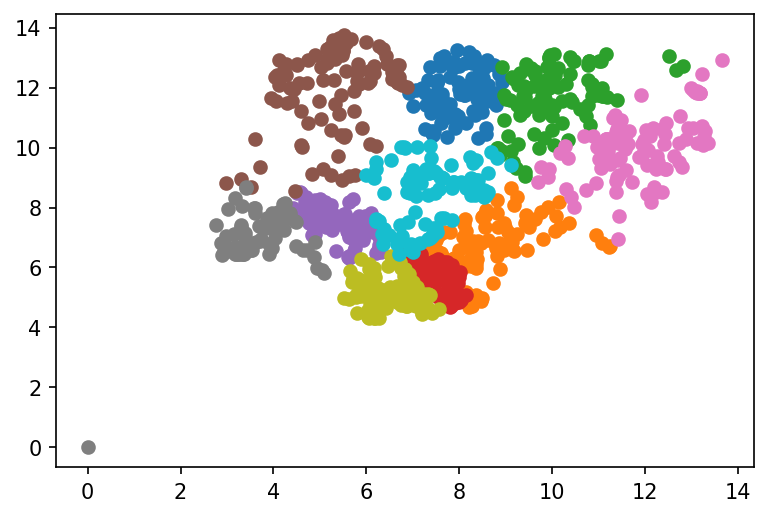

In [47]:
import seaborn as sns 
k = 10
N = 1000
samp_hex = np.random.choice(thr_all['hex_code'], size=N, replace=False)
labels = np.random.rand(N)
folds = cv_split(samp_hex,labels=labels,k=k,mode='spatial')
# sns.distplot(folds,kde=False, bins=k)
fig,ax = plt.subplots(dpi=150) 
latlongs = np.array([h3.h3_to_geo(hex) for hex in samp_hex]) 
for _, test_idxs in folds: 
    ax.scatter(latlongs[test_idxs,1],latlongs[test_idxs,0])
plt.show()

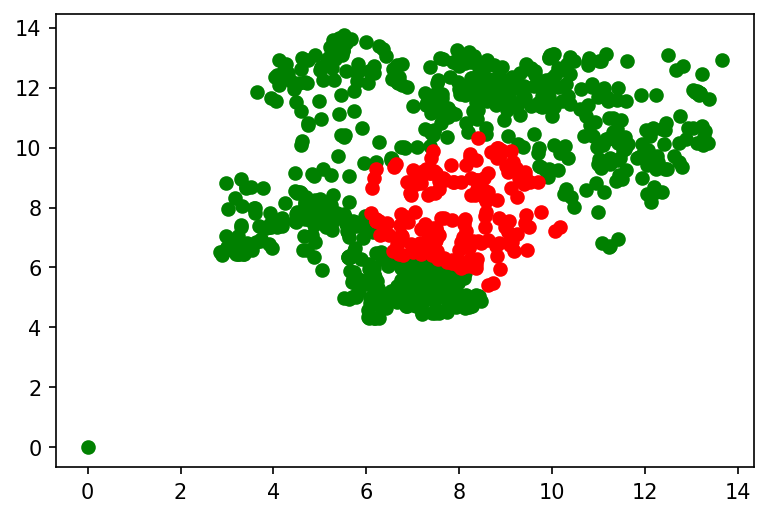

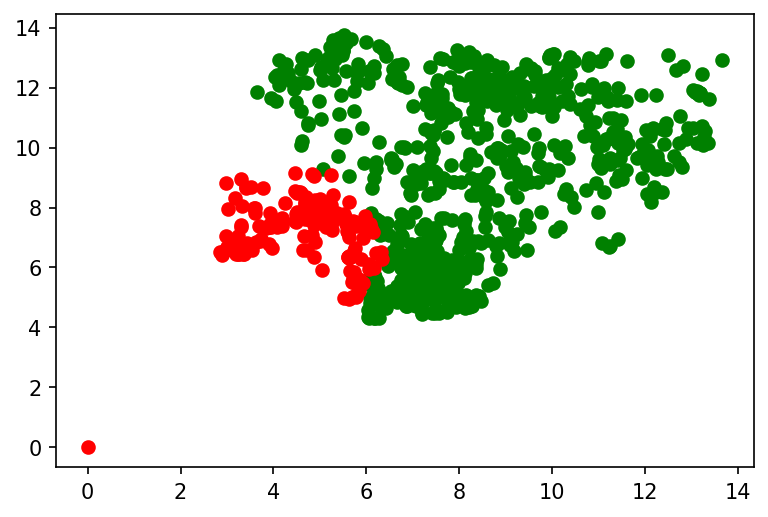

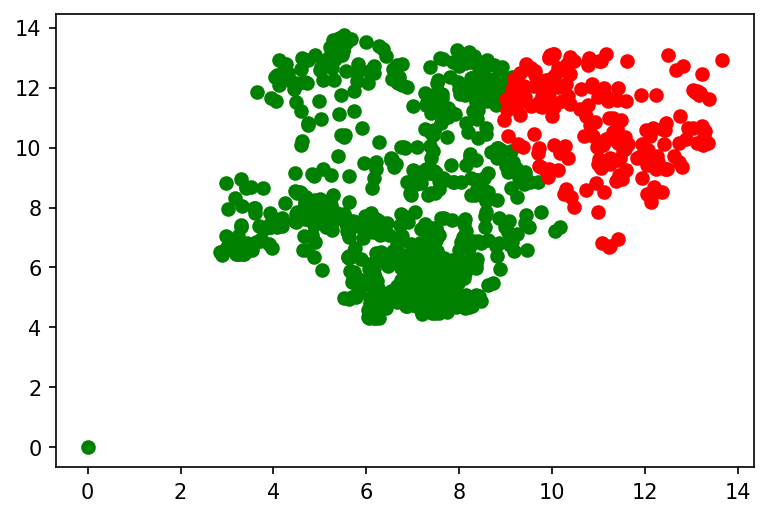

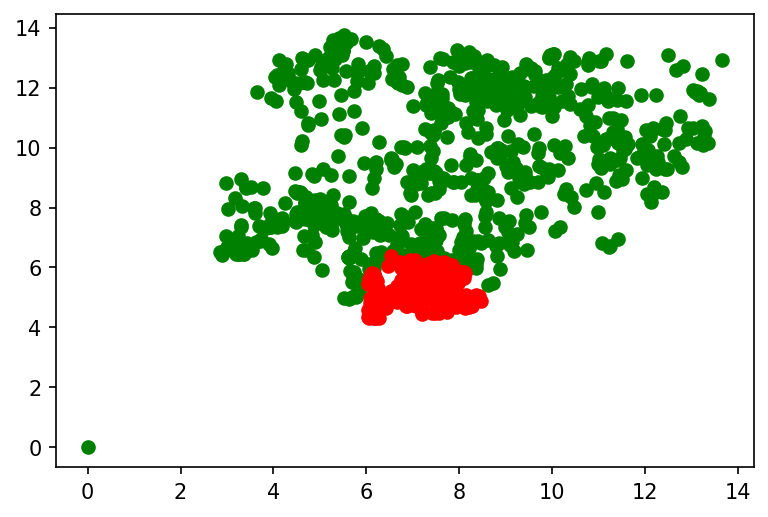

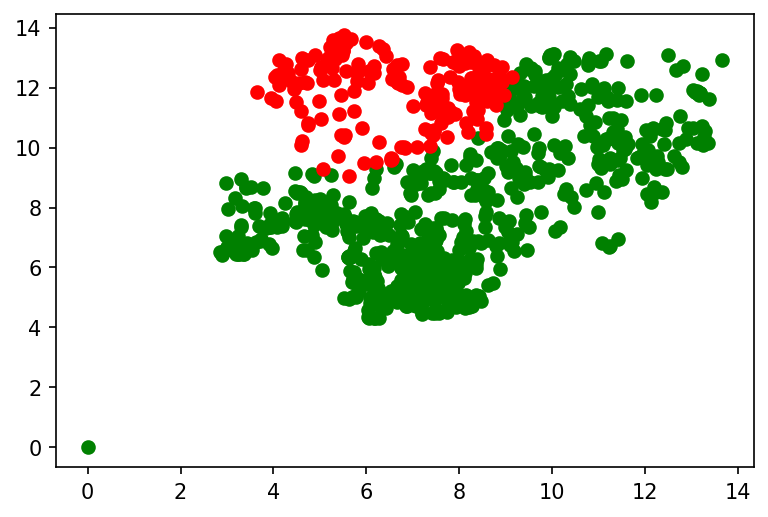

In [41]:
from stc_unicef_cpi.data.cv_loaders import HexSpatialKFold 
latlongs = np.array([h3.h3_to_geo(hex) for hex in samp_hex]) 
for train_idx, test_idx in HexSpatialKFold().split(samp_hex,labels): 
    fig,ax = plt.subplots(dpi=150) 
    ax.scatter(latlongs[train_idx,1],latlongs[train_idx,0],c='g')
    ax.scatter(latlongs[test_idx,1],latlongs[test_idx,0],c='r')
    plt.show()

In [ ]:
base_dir = Path("/Users/johnf/Downloads/higher_res_dssg/")
tiff_dir = base_dir / "500m_res"
econ_dir = base_dir / "econ"
connectivity_dir = base_dir / "connectivity"
clean_base = base_dir / "nga_clean_v2.csv"
rwi_path = base_dir / "NGA_relative_wealth_index.csv"
comm_zns = base_dir / "commuting-zones-bdrys.csv"
fb_conn = connectivity_dir / "fb_nigeria.csv"


In [ ]:
# NB nga has lats between 4.2 and 13.9, longs between 2.6 and 14.7


# Connectivity data

In [ ]:
# import dask.dataframe as dd
# from dask.delayed import delayed
# parts = delayed(pd.read_excel)(connectivity_dir / 'cell_tower_nga.xlsx',
#                                     sheet_name=0)
# df = dd.from_delayed(parts)
nga_cell_df = pd.read_excel(connectivity_dir / "cell_tower_nga.xlsx", sheet_name=0)


In [ ]:
nga_cell_df.head()
# will just want radio (generation category - want counts / cell if possible)
# and possibly avg_signal, though generally 0
# Most likely just overall count will be most useful


In [ ]:
nga_cell_df["hex_code"] = nga_cell_df[["lat", "long"]].swifter.apply(
    lambda x: h3.geo_to_h3(x[0], x[1], resolution=7), axis=1
)


In [ ]:
nga_cell_df = nga_cell_df[["hex_code", "radio", "avg_signal"]]


In [ ]:
nga_cell_df.groupby(["hex_code", "radio"]).size().unstack(level=1).fillna(0).join(
    nga_cell_df.groupby("hex_code").avg_signal.mean()
).to_csv(connectivity_dir / "nga_cell_clean.csv")


In [ ]:
import shapely.wkt

# speed_df = dd.read_csv(connectivity_dir/"speedtest_world.csv",blocksize=25e6).set_index("Unnamed: 0")  # 25MB chunks
speed_df = pd.read_csv(connectivity_dir / "speedtest_world.csv", index_col=0)
speed_df["geometry"] = speed_df.geometry.swifter.apply(shapely.wkt.loads)


In [ ]:
speed_df = gpd.GeoDataFrame(speed_df, crs="epsg:4326")


In [ ]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
nga_speed_df = gpd.sjoin(
    speed_df, world[world.name == "Nigeria"], how="inner", op="intersects"
)


In [ ]:
# def centroid_lat_from_shply(wkt_str):
#     try:
#         return shapely.wkt.loads(wkt_str).centroid.coords.xy[1]
#     except:
#         # assume wkt reading error
#         return np.nan
# def centroid_long_from_shply(wkt_str):
#     try:
#         return shapely.wkt.loads(wkt_str).centroid.coords.xy[0]
#     except:
#         # assume wkt reading error
#         return np.nan

# def centroid_latlong_from_shply(wkt_str):
#     try:
#         return np.array(shapely.wkt.loads(wkt_str).centroid.coords.xy).flatten()
#     except:
#         # assume wkt reading error
#         return np.array([np.nan,np.nan])

# # speed_df['lat'] = speed_df.geometry.apply(centroid_lat_from_shply, meta=('geometry', float))
# # speed_df['long'] = speed_df.geometry.apply(centroid_long_from_shply, meta=('geometry', float))
# # speed_df[['lat','long']] = speed_df.geometry.swifter.apply(centroid_latlong_from_shply)
# speed_df['lat'] = speed_df.geometry.swifter.apply(centroid_lat_from_shply)


In [ ]:
tmp = nga_speed_df.geometry.swifter.apply(
    lambda x: pd.Series(np.array(x.centroid.coords.xy).flatten())
)


In [ ]:
nga_speed_df[["long", "lat"]] = tmp


In [ ]:
nga_speed_df["hex_code"] = nga_speed_df[["lat", "long"]].swifter.apply(
    lambda row: h3.geo_to_h3(row[0], row[1], 7), axis=1
)


In [ ]:
nga_speed_df.to_csv(connectivity_dir / "speedtest_nga.csv", index=False)


# Main data

In [ ]:
nga_df = pd.read_csv(clean_base)


In [ ]:
nga_cell_df = pd.read_csv(connectivity_dir / "nga_cell_clean.csv")
nga_speed_df = pd.read_csv(connectivity_dir / "speedtest_nga.csv")


In [ ]:
nga_speed_df = (
    nga_speed_df[
        ["hex_code", "avg_d_kbps", "avg_u_kbps", "avg_lat_ms", "tests", "devices"]
    ]
    .groupby("hex_code")
    .agg(
        {
            "avg_d_kbps": "mean",
            "avg_u_kbps": "mean",
            "avg_lat_ms": "mean",
            "tests": "sum",
            "devices": "sum",
        }
    )
)


In [ ]:
new_nga_df = nga_df.join(nga_cell_df.set_index("hex_code"), on=["hex_code"]).join(
    nga_speed_df
)
new_nga_df.iloc[:, 92:].fillna(0, inplace=True)


In [ ]:
new_nga_df.n_conflicts.fillna(0, inplace=True)


In [ ]:
new_nga_df.head()


# Reproject CISI data and add in again 

In [ ]:
pg.clip_tif_to_ctry(base_dir / "africa_cisi.tif", save_dir=base_dir)


In [ ]:
pg.rxr_reproject_tiff_to_target(
    base_dir / "Nigeria_africa_cisi.tif",
    tiff_dir / "cpiPopData_500.tif",
    dest_path=base_dir / "nga_cisi.tif",
    verbose=True,
)


In [ ]:
alt_nga_df = pg.agg_tif_to_df(new_nga_df,base_dir / "nga_cisi.tif",rm_prefix='nga_',verbose=True) 

In [ ]:
alt_nga_df.drop(columns=['cii'],inplace=True)

In [ ]:
zero_fill_cols = [
    "GSM",
    "LTE",
    "NR",
    "UMTS",
    "avg_signal",
    "avg_d_kbps",
    "avg_u_kbps",
    "avg_lat_ms",
    "tests",
    "devices",
]
alt_nga_df.fillna(value={col: 0 for col in zero_fill_cols}, inplace=True)
alt_nga_df.head()


In [ ]:
alt_nga_df = pg.agg_tif_to_df(alt_nga_df,tiff_dir / "cpiHealthAccData_500.tif",verbose=True) 

In [ ]:
autoh7 = pd.read_csv(base_dir / "autoencoder_highres7.csv",index_col=0) 
autol7 = pd.read_csv(base_dir / "autoencoder_lowres7.csv",index_col=0)  
autoh7.columns = [f'auto_h{i}' for i in range(len(autoh7.columns))]
autol7.columns = [f'auto_l{i}' for i in range(len(autol7.columns))]

In [ ]:
alt_nga_df = alt_nga_df.join(autoh7,on='hex_code').join(autol7,on='hex_code')

In [ ]:
commute_df = pd.read_csv(base_dir / "nga_clean_justnewcomm_zns.csv")[
    [
        "hex_code",
        "name_commuting_zone",
        "population_commuting",
        "road_len_commuting",
        "area_commuting",
    ]
]

alt_nga_df = alt_nga_df.join(commute_df.set_index('hex_code'),on='hex_code')

In [ ]:
alt_nga_df.to_csv(base_dir / "clean_nga_w_autov1.csv",index=False)

# Try mapping data to neighbours

In [ ]:
full_nga_data = pd.read_csv(
    "/Users/johnf/Downloads/raw_low_res_dssg/dhs/clean_nga_dhs.csv"
)


In [ ]:
plt.scatter(nga_df.LONGNUM, nga_df.LATNUM, c=nga_df.location)
plt.colorbar()
plt.show()


In [ ]:
full_nga_data.location.astype("category").describe()
# 1 is urban, 2 is rural


In [ ]:
full_nga_data["hex_incl_nbrs"] = full_nga_data[["location", "hex_code"]].apply(
    lambda row: h3.k_ring(row["hex_code"], 1)
    if row["location"] == 1
    else h3.k_ring(row["hex_code"], 2),
    axis=1,
)  # h3.hex_ring for hollow


In [ ]:
sev_cols = [col for col in full_nga_data.columns if "_sev" in col]


In [ ]:
other_cols = [
    col
    for col in full_nga_data.columns
    if (
        "int" in str(full_nga_data[col].dtype)
        or "float" in str(full_nga_data[col].dtype)
    )
]
agg_dict = {col: "mean" for col in other_cols}
agg_dict.update({idx: ["mean", "count"] for idx in sev_cols})
# agg_dict.update({"hhid": "count"})
new_df = (
    full_nga_data.explode("hex_incl_nbrs").groupby(by=["hex_incl_nbrs"]).agg(agg_dict)
)
new_df.columns = ["_".join(col) for col in new_df.columns.values]


In [ ]:
sev_cols


In [ ]:
new_df.rename(
    columns={
        f"{sev}_mean": f"{sev.lstrip('dep_').rstrip('_sev')}_prev"
        for sev in sev_cols
        if sev != "deprived_sev"
    },
    inplace=True,
)
new_df.rename(
    columns={
        f"{sev}_count": f"{sev.lstrip('dep_').rstrip('_sev')}_count"
        for sev in sev_cols
        if sev != "deprived_sev"
    },
    inplace=True,
)
new_df.rename(
    columns={"ucation_count": "education_count", "ucation_prev": "education_prev"},
    inplace=True,
)


In [ ]:
new_df.head().columns


In [ ]:
new_df.to_csv(base_dir / "nga_clean_expanded.csv")


In [ ]:
new_df = pd.read_csv(base_dir / "nga_clean_expanded.csv")
new_df[new_df["nutrition_count"] >= 10]


In [ ]:
sev_cols = [col for col in full_nga_data.columns if "sev" in col]


In [ ]:
full_nga_data["ndeps_missing"] = full_nga_data[sev_cols].isna().sum(axis=1)


In [ ]:
((6 - full_nga_data["ndeps_missing"] - full_nga_data["sumpoor_sev"]) < 0).sum()


In [ ]:
full_nga_data.ndeps_missing.describe()


In [ ]:
full_nga_data[sev_cols].info()


In [ ]:
full_nga_data.age.describe()


In [ ]:
# one vs all training


In [ ]:
import h3.api.numpy_int as h3


In [ ]:
res_level = 3
for col in sev_cols:
    full_nga_data[f"hex_code{res_level}"] = full_nga_data[["LATNUM", "LONGNUM"]].apply(
        lambda row: h3.geo_to_h3(*row.values, res_level), axis=1
    )
    count_df = full_nga_data.groupby(f"hex_code{res_level}")[col].count()
    _, bins = pd.qcut(count_df, [0, 0.05, 1.0], retbins=True)
    # print(f"5% cutoff for {col} is at {bins[1]}")
    if bins[1] < 30:
        quants = pd.cut(count_df, [0, 30, np.inf])
        cut_prop = quants.value_counts().sort_index().values[0] / len(count_df)
        print(f"Warning: cutoff at 30 for {col} removes {cut_prop*100:.2f}% of data")
        print(f"5% cutoff is at {bins[1]}")
        for thresh in [5, 10, 15, 20]:
            quants = pd.cut(count_df, [0, thresh, np.inf])
            cut_prop = quants.value_counts().sort_index().values[0] / len(count_df)
            print(f"Cutoff at {thresh} for {col} removes {cut_prop*100:.2f}% of data")
# count_df.hist(bins=100)
# plt.show()


In [ ]:
thr_df = nga_df.loc[count_df.values >= 30].copy()


In [ ]:
thr_df.to_csv(clean_base.parent / "nga_clean_v2_thr30.csv", index=False)


# First add higher res TIFF data

In [ ]:
nga_df = pd.read_csv(clean_base)


In [ ]:
nga_df = pg.agg_tif_to_df(
    nga_df,
    tiff_dir,
    rm_prefix="cpi",
    agg_fn=np.mean,
    max_records=int(1e5),
    replace_old=True,
    verbose=False,
)


In [ ]:
merge_cols = [col for col in nga_df.columns if "Data_500" in col]
old_cols = [col for col in merge_cols if col.rstrip("Data_500") in nga_df.columns]
nga_df.drop(columns=old_cols, inplace=True)
nga_df.rename(columns={col: col.rstrip("Data_500") for col in merge_cols}, inplace=True)


In [ ]:
nga_df.to_csv(clean_base, index=False)


In [ ]:
pd.set_option("display.max_columns", None)
nga_df.head()


# Now add econ TIFF data

In [ ]:
nga_df = pd.read_csv(clean_base)


In [ ]:
import glob

econ_tiffs = glob.glob(str(econ_dir / "*.tif"))


In [ ]:
econ_tiffs


In [ ]:
import rioxarray as rxr

# Convert econ tiffs to right resolution + CRS, rewrite to high_res dir
for i, econ_tiff in enumerate(econ_tiffs):
    with rxr.open_rasterio(econ_tiff) as data:
        name = Path(econ_tiff).name
        if "GDP_PPP" in name:
            data.attrs["long_name"] = ["GDP_PPP_1990", "GDP_PPP_2000", "GDP_PPP_2015"]
        elif "2019GDP" in name:
            data.attrs["long_name"] = ["GDP_2019"]
        elif "EC" in name:
            data.attrs["long_name"] = ["EC_2019"]
        data.rio.to_raster(econ_tiff)
    pg.rxr_reproject_tiff_to_target(
        econ_tiff,
        glob.glob(str(tiff_dir / "*.tif"))[0],
        tiff_dir / Path(econ_tiff).name,
        verbose=True,
    )


In [ ]:
high_res_econ_tifs = [
    name
    for name in glob.glob(str(tiff_dir / "*.tif"))
    if "GDP" in Path(name).name or "EC" in Path(name).name
]


In [ ]:
high_res_econ_tifs


In [ ]:
nga_df = pg.agg_tif_to_df(
    nga_df,
    high_res_econ_tifs,
    rm_prefix="Nigeria_",
    agg_fn=np.mean,
    max_records=int(1e5),
    replace_old=True,
    verbose=False,
)


In [ ]:
nga_df.head()


In [ ]:
nga_df.to_csv(clean_base, index=False)


# Now add commuter zone data

In [ ]:
nga_df = pd.read_csv(clean_base)


In [ ]:
import geopandas as gpd

commzns_df = pd.read_csv(comm_zns)


In [ ]:
from shapely import wkt

commzns_df["geometry"] = commzns_df["geometry"].apply(wkt.loads)


In [ ]:
commzns_df = gpd.GeoDataFrame(commzns_df, crs="epsg:4326")


In [ ]:
commzns_df[commzns_df["country"] == "Nigeria"].head(2)


In [ ]:
# TODO: decide if will add


In [ ]:
nga_df.to_csv(clean_base, index=False)


# Now add FB connectivity data

In [ ]:
nga_df = pd.read_csv(base_dir / "clean_nga_w_autov1.csv")


In [ ]:
conn_df = pd.read_csv(fb_conn)
conn_gdf = gpd.GeoDataFrame(
    conn_df, geometry=gpd.points_from_xy(conn_df.long, conn_df.lat)
)


In [ ]:
conn_df['hex_code']=conn_df[['lat','long']].swifter.apply(lambda row: h3.geo_to_h3(row[0],row[1],resolution=7),axis=1)

In [ ]:
nga_df = nga_df.join(conn_df.set_index('hex_code')['estimate_dau'],on='hex_code')

In [ ]:
nga_df.to_csv(base_dir / "clean_nga_w_autov1.csv", index=False)

In [ ]:
# only for inside train set - worth including or not extensible?
conn_gdf.plot()


In [ ]:
nga_df.to_csv(clean_base, index=False)


# Finally add RWI data

In [ ]:
nga_df = pd.read_csv(clean_base)


In [ ]:
from pyquadkey2 import quadkey as qk
from shapely.geometry import Polygon

# qk.QuadKey()
top_left = qk.TileAnchor.ANCHOR_NW
top_right = qk.TileAnchor.ANCHOR_NE
bottom_right = qk.TileAnchor.ANCHOR_SE
bottom_left = qk.TileAnchor.ANCHOR_SW
getattr(qk.TileAnchor, bottom_right)


In [ ]:
test_idx = "010302121"
square = [
    qk.from_str(test_idx).to_geo(anchor=point)
    for point in [top_left, top_right, bottom_right, bottom_left]
]
square = Polygon(square)


In [ ]:
import h3.api.numpy_int as h3

ex_idx = h3.geo_to_h3(*square.boundary.coords[0], resolution=6)
hex = Polygon(h3.h3_to_geo_boundary(ex_idx))


In [ ]:
# create intersection and calculate percentage intersection based on areas
intersection = hex.intersection(square)
percent_area = intersection.area / square.area * 100


In [ ]:
percent_area


In [ ]:
nga_df.to_csv(clean_base, index=False)
